In [1]:
from datetime import date
from collections import defaultdict
import warnings

import periodictable
import numpy as np

import qcportal
from qcportal.external import scaffold
from qcportal.molecules import Molecule
from qcportal.singlepoint import SinglepointDriver, QCSpecification

ADDRESS = "https://api.qcarchive.molssi.org:443"
#qc_client = qcportal.PortalClient(ADDRESS, cache_dir=".")
from qcfractal.snowflake import FractalSnowflake
import warnings
import logging
snowflake = FractalSnowflake()
client = snowflake.client()

## Assembled Dataset

In [2]:
dataset_name = "OpenFF TMC Atom Energies v0.0"
tagline = "Element energies at various multiplicities, and formal charges of +1, 0, and -1. Elements include C, H, P, S, O, N, F, Cl, B, Li, Na, K, Mg, Ca, Br, Pd, Fe, Zn, Cu, Rh, Ir, Pt, Ni, Cr, Ag, Ti at the following model chemistries: B3LYP-D3BJ/DZVP, BP86/def2-TZVP, wB97M-V/def2-TZVPD, wB97M-D3BJ/def2-TZVPPD."
description = ("""
This dataset generates the per atom energies for use in calculating formation energies. The model chemistries chosen are: 
 B3LYP-D3BJ/DZVP (OpenFF default), BP86/def2-TZVP (used in OpenFF tmQM), wB97M-V/def2-TZVPD (OMol25), wB97M-D3BJ/def2-TZVPPD
 (SPICE). Elements include C, H, P, S, O, N, F, Cl, B, Li, Na, K, Mg, Ca, Br, Pd, Fe, Zn, Cu, Rh, Ir, Pt, Ni, Cr, Ag, Ti.
 Each atom is run at a charge of -1, 0, 1 for nonmetals, 0, 1 for alkali metals, 0, 1, 2 for alkaline earth metals, and -2,
 -1, 0, 1, 2 for transition metals. Each element / charge combination is run for valid multiplicities up to 6 with a reference of uks. 
 The molecular weight varies with elemental values from 1.008 for H to 195.085 for Pt. Entry names for this dataset are:
 "{element symbol}_{charge}_{multiplicity}"
""")

dataset = client.add_dataset( # https://docs.qcarchive.molssi.org/user_guide/qcportal_reference.html
    "singlepoint", # collection type
    dataset_name, # Dataset name
    tagline=tagline,
    description=description,
    tags=["openff"],
    provenance={
        "qcportal": qcportal.__version__,
    },
    default_tag="openff",
    extras={
        "submitter": "jaclark5",
        "creation_date": date.today(),
        'collection_type': 'SinglepointDataset',
        "long_description": description,
        'long_description_url': f'https://github.com/openforcefield/qca-dataset-submission/tree/master/submissions/{dataset_name.replace(" ", "-")}',
        "short_description": tagline,
        "dataset_name": dataset_name,
    },
)

In [3]:
elements_classes = {
    "nonmetals": {
        "elements": ["C", "H", "P", "S", "O", "N", "F", "Cl", "Br", "B"],
        "charges": [-1, 0, 1],
        "multiplicities": list(range(1,6)),
    },
    "alkali metal": {
        "elements": ["Li", "Na", "K", ],
        "charges": [0, 1],
        "multiplicities": list(range(1,6)),
    },
    "alkaline earth metal": {
        "elements": ["Mg", "Ca",],
        "charges": [0, 1, 2],
        "multiplicities": list(range(1,6)),
    },
    "transition metal": {
        "elements": ["Pd", "Fe", "Zn", "Cu", "Rh", "Ir", "Pt", "Ni", "Cr", "Ag", "Ti"],
        "charges": [-2, -1, 0, 1, 2],
        "multiplicities": list(range(1,6)),
    }, 
}


elements, molecular_weights, charges = [], [], []

errors_mult = []
errors_misc = defaultdict(lambda: defaultdict(list))
count_molecules = 0
pairs = defaultdict(list)

for i, (elclass, class_dict) in enumerate(elements_classes.items()):
    for sym in class_dict["elements"]:
        for chg in class_dict["charges"]:
            for mult in class_dict["multiplicities"]:
                label = f"{sym}_{chg}_{mult}"
                try:
                    m_w = getattr(periodictable, sym).mass
                    smiles = f"[{sym}{('+'+str(chg)) if chg > 0 else (str(chg) if chg < 0 else '')}:0]"
                    molecule = Molecule(
                        name=label,
                        fix_com=True,
                        fix_orientation=True,
                        symbols=[sym],
                        geometry=np.array([0,0,0]),
                        molecular_charge=chg,
                        molecular_multiplicity=mult,
                        identifiers={
                            "smiles": smiles,
                            "molecular_formula": sym,
                        },
                        extras={'molecular_weight': m_w}
                    )

                    dataset.add_entry(
                        name=label,
                        molecule=molecule,
                        attributes={"canonical_isomeric_explicit_hydrogen_mapped_smiles": smiles},
                    )

                    molecular_weights.append(m_w)
                    elements.append(sym)
                    charges.append(chg)
                    count_molecules += 1
                    pairs[sym].append([chg, mult])
                except Exception as e:
                    if "Inconsistent or unspecified chg/mult" in str(e):
                        errors_mult.append(label)
                    else:
                        errors_misc[str(e)[:30]][label].append([i, str(e)])
                    continue

elements = sorted(list(set(elements))) 
dataset.extras["elements"] = elements
charges = sorted(list(set(charges)))   



c: [-1, 0]
fc: [-1, 0.0]
m: [1]
fm: [1, 1, 2]


c: [-1, 0]
fc: [-1, 0.0]
m: [3]
fm: [3, 1, 2]


c: [-1, 0]
fc: [-1, 0.0]
m: [5]
fm: [5, 1, 2]


c: [0, 0]
fc: [0, 0.0]
m: [2]
fm: [2, 1, 2]


c: [0, 0]
fc: [0, 0.0]
m: [4]
fm: [4, 1, 2]


c: [1, 0]
fc: [1, 0.0]
m: [1]
fm: [1, 1, 2]


c: [1, 0]
fc: [1, 0.0]
m: [3]
fm: [3, 1, 2]


c: [1, 0]
fc: [1, 0.0]
m: [5]
fm: [5, 1, 2]


c: [-1, 0]
fc: [-1, 0.0]
m: [2]
fm: [2, 1, 2]


c: [-1, 0]
fc: [-1, 0.0]
m: [4]
fm: [4, 1, 2]


c: [-1, 0]
fc: [-1, 0.0]
m: [5]
fm: [5, 1, 2]


c: [0, 0]
fc: [0, 0.0]
m: [1]
fm: [1, 1, 2]


c: [0, 0]
fc: [0, 0.0]
m: [3]
fm: [3, 1, 2]


c: [0, 0]
fc: [0, 0.0]
m: [4]
fm: [4, 1, 2]


c: [0, 0]
fc: [0, 0.0]
m: [5]
fm: [5, 1, 2]


c: [1, 0]
fc: [1, 0.0]
m: [2]
fm: [2, 1, 2]


c: [1, 0]
fc: [1, 0.0]
m: [3]
fm: [3, 1, 2]


c: [1, 0]
fc: [1, 0.0]
m: [4]
fm: [4, 1, 2]


c: [1, 0]
fc: [1, 0.0]
m: [5]
fm: [5, 1, 2]


c: [-1, 0]
fc: [-1, 0.0]
m: [2]
fm: [2, 1, 2]


c: [-1, 0]
fc: [-1, 0.0]
m: [4]
fm: [4, 1, 2]


c: [0, 0]
fc: [0

In [4]:
print(f"Number of molecules removed for unspecified chg/mult: {len(errors_mult)}")
print(f"Number of conformers accepted: {len(dataset.entry_names)}")

Number of molecules removed for unspecified chg/mult: 243
Number of conformers accepted: 242


In [5]:
print(f"{len(dataset.entry_names)} element / chg / multiplicity combinations were imported.")

print("\nThe following errors DO remove molecules from the dataset:")
if not errors_misc:
    print("    None")
for err, values in errors_misc.items():
    print(f"    {len(values)}: '{err}'")

242 element / chg / multiplicity combinations were imported.

The following errors DO remove molecules from the dataset:
    None


In [6]:
specs = [("B3LYP-D3BJ", "DZVP"), ("BP86", "def2-TZVP"), ("wB97M-V", "def2-TZVPD"), ("wB97M-D3BJ", "def2-TZVPPD")]

for method, basis in specs:
    spec = QCSpecification(
        program='psi4',
        driver=SinglepointDriver.energy,
        method=method,
        basis=basis,
        keywords={
            "reference": "uks",
            "maxiter": 500,
            "function_kwargs": {"properties": ["dipole_polarizabilities"]},
        },
        protocols={'wavefunction': 'none'}
    )
    dataset.add_specification(name=f"{method}/{basis}", specification=spec)

In [7]:
dataset.submit()
scaffold.to_json(dataset, compress=True)

## Make Outputs

In [8]:
print("Elements:", dataset.extras["elements"])
print("Charges:", sorted(set(charges)))
print("Molecular Weight (min mean max):", int(np.min(molecular_weights)), int(np.mean(molecular_weights)), int(np.max(molecular_weights)))
            
print("Number of Elements:", len(elements))
print("Number of Element / Charge / Mult Combinations:", len(dataset.entry_names))

Elements: ['Ag', 'B', 'Br', 'C', 'Ca', 'Cl', 'Cr', 'Cu', 'F', 'Fe', 'H', 'Ir', 'K', 'Li', 'Mg', 'N', 'Na', 'Ni', 'O', 'P', 'Pd', 'Pt', 'Rh', 'S', 'Ti', 'Zn']
Charges: [-2, -1, 0, 1, 2]
Molecular Weight (min mean max): 1 65 195
Number of Elements: 26
Number of Element / Charge / Mult Combinations: 242


The following elements are not represented: []


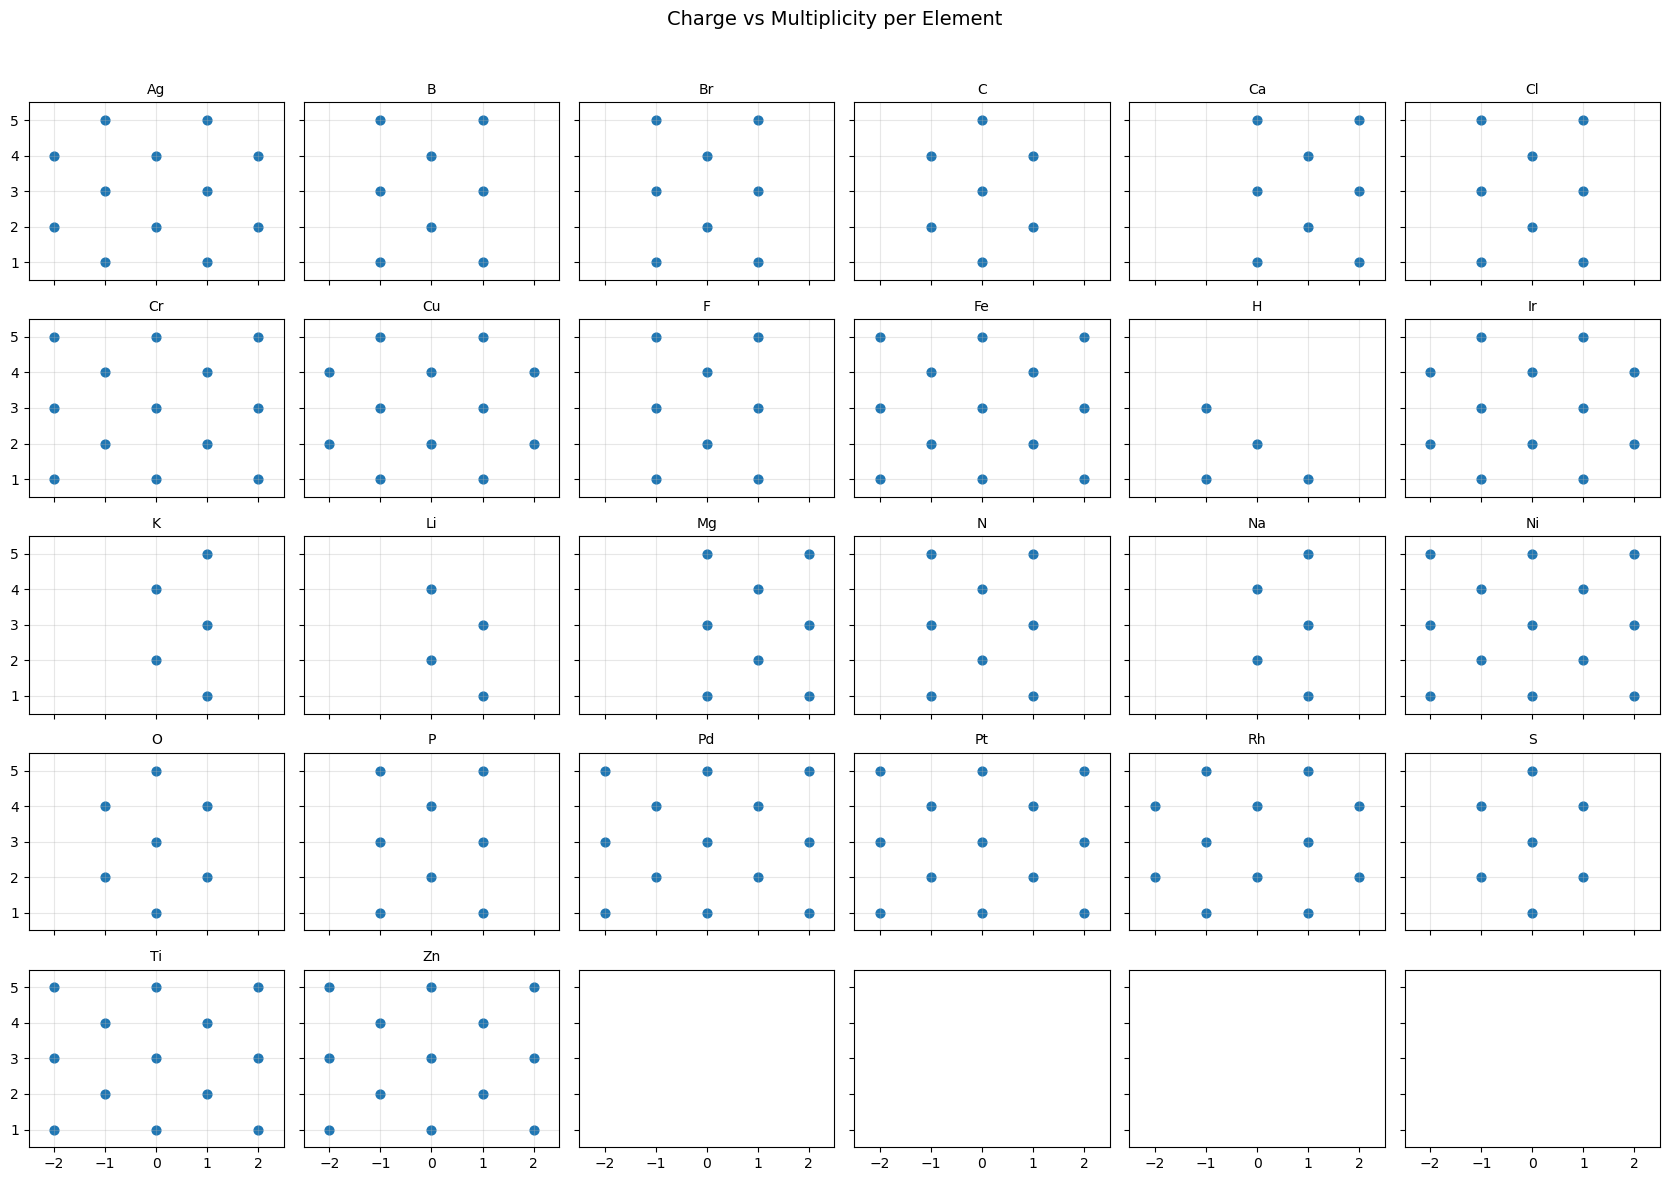

In [9]:
from math import ceil

import matplotlib.pyplot as plt

# choose elements to plot (preserve dataset order if available)
elems = dataset.extras.get("elements", sorted(pairs.keys()))
elems = [e for e in elems if e in pairs]  # only those with data
print(f"The following elements are not represented: {[e for e in elems if e not in pairs]}")

# global axis ranges
all_mults = [m for v in pairs.values() for _, m in v]
all_chgs = [c for v in pairs.values() for c, _ in v]
if not all_mults:
    raise RuntimeError("No (charge, multiplicity) pairs found in `pairs`.")

min_chg, max_chg = min(all_chgs), max(all_chgs)
min_mult, max_mult = min(all_mults), max(all_mults)

n = len(elems)
ncols = min(6, n)
nrows = ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 2.8, nrows * 2.4), sharex=True, sharey=True)
axes = axes.flatten()

for i, sym in enumerate(elems):
    ax = axes[i]
    pts = pairs[sym]
    xs = [c for c, m in pts]
    ys = [m for c, m in pts]
    ax.scatter(xs, ys, s=40, color="C0")
    ax.set_title(sym, fontsize=10)
    ax.set_xlim(min_chg - 0.5, max_chg + 0.5)
    ax.set_ylim(min_mult - 0.5, max_mult + 0.5)
    ax.set_xticks(sorted(set(all_chgs)))
    ax.set_yticks(range(min_mult, max_mult + 1))
    ax.grid(alpha=0.3)



fig.suptitle("Charge vs Multiplicity per Element", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()